# Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Understanding our data

## Training/Test Data Preprocessing

**Steps Taken:**
- Replace missing data coded as ‘na’ with NaN
- Map binary-valued column ‘class’ to {-1,1} to make it suitable for the deep net model that is going to use tanh() as the activation function (not covered in this project) 
- Impute missing values using K-nearest neighbors estimate of the fancyimpute python package. Do this separately for training and test data.
- Normalize feature columns to zero mean, unit variance in training data. Apply normalization coefficients calculated for training data to test data.
- Clip feature columns to [-1,1] to dampen the effect of outliers
- Convert the single class variable to two classes. One for ‘-1’, the other for ‘+1’. For this binary classifications, use two outputs instead of one. Consider higher of the two outputs as the winning class while validating/testing. This methodology avoids the work required to find the most suitable output threshold at which the classification switches from one class to the other, eliminating the need for an ROC curve.
- End result: 170 feature columns + 2 class columns
- Make training & test data suitable for an 8-bit, fixed-point representation in the range [-0.9921875, 0.9921875]. This, along with an 8-bit fixed-point tanh() lookup table, will allow the forward pass to take place through integer-only math, and without the need for multiplications. (which will be converted to 0 & 1) 
- Create stratified ‘learning data subset’ and ‘validation data subset’ from the training data set, with a 70-30 split.

    - n_total_training 60,000
    - n_total_learning 42,000 70%
        - n_neg_learning 41,300 98.3%
        - n_pos_learning 700 1.7%
    - n_total_validation 18,000 30%
        - n_neg_validation 17,700 98.3%
        - n_pos_validation 300 1.7%
- Create balanced ‘learning’ data subset by oversampling the minority class.
    - n_neg_training 41,300 50%
    - n_pos_training 41,300 50%
    - n_neg_validation 17,700 98.3%
    - n_pos_validation 300 1.7%

- Test data.
    - n_test 16,000
        - n_neg_test 15,625 97.7%
        - n_pos_test 375 2.3%

Credit goes to @ahk3 on Kaggle community 

For more information visit this url: https://www.kaggle.com/ahkahk/8-16-bit-low-precision-deep-net

In [2]:
"""
# The code in this cell was used for training and test data preprocessing.
# The imputing steps take far too long and require vast amount of resources.
# Instead of running those steps, the next cell loads pre-processed training/test data
# In case you want to run this cell, delete the first and last line of this cell,
# and comment out the next cell

random_seed = 72
random.seed(random_seed)
np.random.seed(random_seed)

data_tr = pd.read_csv("../input/aps_failure_training_set.csv")
data_ts = pd.read_csv("../input/aps_failure_test_set.csv")

# TRAINING AND TEST DATA PREPROCESSING
data_tr_processed = data_tr
data_ts_processed = data_ts

# map {neg,pos} to {-1,1} in the class column
data_tr_processed['class'] = data_tr_processed['class'].map({'neg':-1, 'pos':1})
data_ts_processed['class'] = data_ts_processed['class'].map({'neg':-1, 'pos':1})

# replace 'na' with NaN
data_tr_processed.replace('na', np.nan, inplace = True)
data_ts_processed.replace('na', np.nan, inplace = True)

from fancyimpute import KNN   # used for imputing missing values

# imputing 20000 records at a time as doing 60000 in one shot crashes the kernel
data_a = pd.DataFrame(KNN(3).complete(data_tr_processed.iloc[    0 : 20000]))
data_b = pd.DataFrame(KNN(3).complete(data_tr_processed.iloc[20000 : 40000]))
data_c = pd.DataFrame(KNN(3).complete(data_tr_processed.iloc[40000 : 60000]))

data_ts_processed = pd.DataFrame(KNN(3).complete(data_tr_processed))

# save column headings and row indices of the dataframe for later
cols    = data_tr_processed.columns
idx_tr  = data_tr_processed.index
idx_ts  = data_ts_processed.index

data_tr_processed = pd.concat([data_a, data_b, data_c])
lst = [data_a, data_b, data_c]
del data_a, data_b, data_c
del lst

# restore column headings and row indices
data_tr_processed.columns = data_ts_processed.columns = cols
data_tr_processed.index   = idx_tr
data_ts_processed.index   = idx_ts

# normalize non-categorical columns to zero mean, unit variance 
for feature in np.delete(cols, 0):
    scaler = StandardScaler()
    scaler.fit(                                   data_tr_processed[feature].reshape(-1, 1))
    data_tr_processed[feature] = scaler.transform(data_tr_processed[feature].reshape(-1, 1))
    data_ts_processed[feature] = scaler.transform(data_ts_processed[feature].reshape(-1, 1))
    
# clip non-categorical columns to unit variance, i.e. [-1,1]    
data_tr_processed = data_tr_processed.clip(-1.0, 1.0)
data_ts_processed = data_ts_processed.clip(-1.0, 1.0)

# nearly_one is the largest fraction that can be represented by n_bits_after_point, e.g. for 7 bits, 0b0.1111111 = 0.9921875
n_bits_after_point = 7
f           = 2 ** n_bits_after_point
nearly_one  = 1.0 - 1.0 / f

data_tr_processed = np.round(data_tr_processed * (f - 1)) / f  # np.roud(data * nearly_one * f) / f
data_ts_processed = np.round(data_ts_processed * (f - 1)) / f
"""

'\n# The code in this cell was used for training and test data preprocessing.\n# The imputing steps take far too long and require vast amount of resources.\n# Instead of running those steps, the next cell loads pre-processed training/test data\n# In case you want to run this cell, delete the first and last line of this cell,\n# and comment out the next cell\n\nrandom_seed = 72\nrandom.seed(random_seed)\nnp.random.seed(random_seed)\n\ndata_tr = pd.read_csv("../input/aps_failure_training_set.csv")\ndata_ts = pd.read_csv("../input/aps_failure_test_set.csv")\n\n# TRAINING AND TEST DATA PREPROCESSING\ndata_tr_processed = data_tr\ndata_ts_processed = data_ts\n\n# map {neg,pos} to {-1,1} in the class column\ndata_tr_processed[\'class\'] = data_tr_processed[\'class\'].map({\'neg\':-1, \'pos\':1})\ndata_ts_processed[\'class\'] = data_ts_processed[\'class\'].map({\'neg\':-1, \'pos\':1})\n\n# replace \'na\' with NaN\ndata_tr_processed.replace(\'na\', np.nan, inplace = True)\ndata_ts_processed.rep

## Label Encode

In [3]:
# Read Original Train and Test set
df = pd.read_csv('aps_failure_training_set_processed_8bit.csv')
df_test = pd.read_csv('aps_failure_test_set_processed_8bit.csv')

# Label encode 'class' for training set
le = LabelEncoder()
le.fit(df['class'])
df['class'] = le.transform(df['class'])

# Label encode 'class' for test set
le = LabelEncoder()
le.fit(df_test['class'])
df_test['class'] = le.transform(df_test['class'])

# print the label encoding
for i, item in enumerate(le.classes_):
    print(item, '=>', i)

-0.9921875 => 0
0.9921875 => 1


## Missing Data

In [4]:
print('null value = ', df.isnull().sum().max())

null value =  0


There appears to be no missing data in the 8-bit processed dataset. 

## Check Class Distributions

Non-APS component failures 98.33 % of the dataset
APS component failures 1.67 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: Non-APS component failures || 1: APS component failures)')

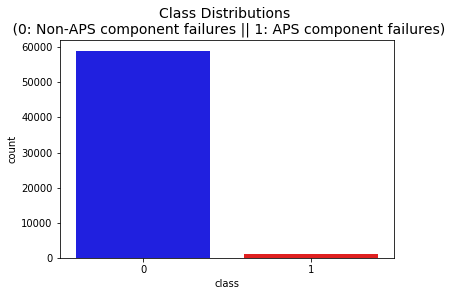

In [5]:
# The classes are heavily skewed we need to solve this issue later.
print('Non-APS component failures', round(df['class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('APS component failures', round(df['class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# visualize distribution
colors = ["blue", "red"]

sns.countplot('class', data = df, palette = colors)
plt.title('Class Distributions \n (0: Non-APS component failures || 1: APS component failures)', fontsize = 14)

# Pre-processing

Before proceeding with the **Random UnderSampling technique** we have to separate the orginal dataframe. **Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques.** The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

# Preparing feature matrix and response vector
X = df.drop('class', axis = 1)
y = df['class']

# Instantiate Stratified Shuffle Split 
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Train Test Split according to the sss indices
for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
""" We also have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables. """

Train: [39839 57649 11862 ... 23126 56211 37338] Test: [51064 42770 54787 ... 24614 44228 21728]
Train: [31134  3359  6563 ... 50329 20746 38142] Test: [23697 25983  6923 ...  3914 44970 44894]
Train: [ 2973 57506 26007 ... 16592 35837 55236] Test: [ 3025 17873 18693 ... 12119 53056 52188]
Train: [33534 22627  5992 ... 50040 34559  2104] Test: [57509 12698 54514 ... 49112 13657 16252]
Train: [ 1744 50128 32356 ...  7373   543  4486] Test: [43386 47869 29664 ... 58545 17140 26672]


' We also have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables. '

# Random Undersampling

In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more **balanced dataset** and thus avoiding our models to overfitting.

**Steps:**
- The first thing we have to do is determine how **imbalanced** is our class (use "value_counts()" on the class column to determine the amount for each label, which was done in section 1.3)
- Once we determine how many instances are considered **APS component failures** (class = "1") , we should bring the **non-APS component failures** (class = "0") to the same frequency as APS component failures case (assuming we want a 50/50 ratio), this will be equivalent to 1,000 cases of APS component failures and 1000 cases of non-APS component failures.
- After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to **shuffle the data** to see if our models can maintain a certain accuracy everytime we run this script.

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of **information loss** (bringing 1,000 non-APS comp failures from 59,000 non-APS comp failures)

## Random Undersampling

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: class, dtype: float64


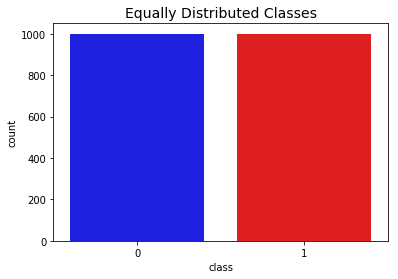

In [7]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes 
# let's shuffle the data before creating subsamples
df = df.sample(frac = 1)

# amount of APS failures classess 1000 rows. 
APS_fail = df.loc[df['class'] == 1]
non_APS_fail = df.loc[df['class'] == 0][:1000]

normal_distributed_df = pd.concat([APS_fail, non_APS_fail])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac = 1, random_state = 42)

# Check distribution class distributions of the undersampled set
print('Distribution of the Classes in the subsample dataset')
print(new_df['class'].value_counts()/len(new_df))

sns.countplot('class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Dimensionality Reduction and Clustering 

Summary:
- t-SNE algorithm can pretty accurately cluster the cases that were APS component failures and non-APS component failures in our dataset.
- Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)
- This gives us an indication that further predictive models will perform pretty well in separating APS component failures from non-APS component failures.

In [8]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('class', axis=1)
y = new_df['class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.5e+01 s
PCA took 0.015 s
Truncated SVD took 0.011 s


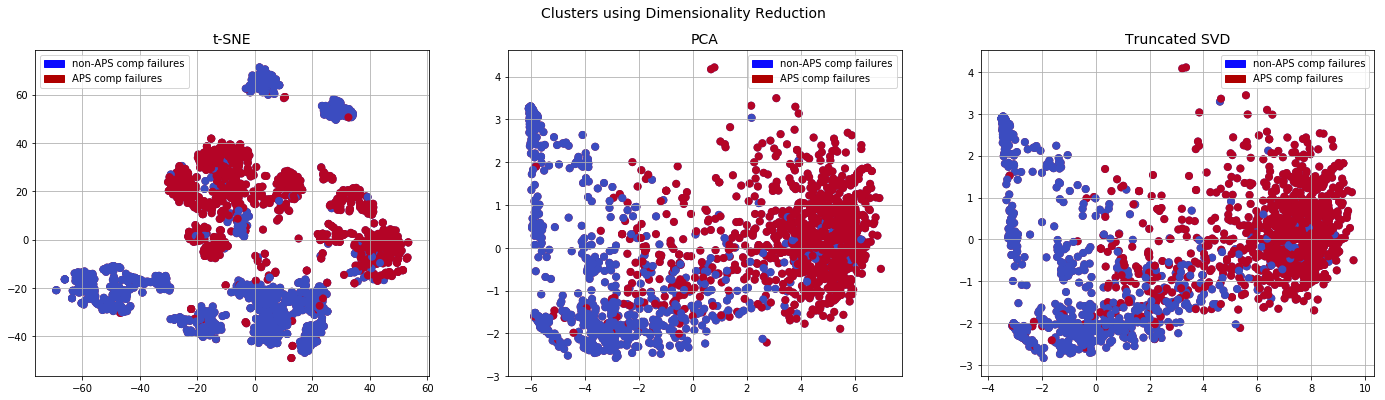

In [9]:
f , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['Non-APS comp failures', 'APS comp failures']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='non-APS comp failures')
red_patch = mpatches.Patch(color='#AF0000', label='APS comp failures')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='non-APS comp failures', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='APS comp failures', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='non-APS comp failures', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='APS comp failures', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='non-APS comp failures', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='APS comp failures', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

## Classifiers

**Classifiers (UnderSampling):** 

In this section we will train four types of classifiers and decide which classifier will be more effective in detecting **APS component failures**. Before we have to split our data into training and testing sets and separate the features from the labels.

**Summary:**
- **Logistic Regression** classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression)
- **GridSearchCV** is used to determine the paremeters that gives the best predictive score for the classifiers.
- Logistic Regression has the best Receiving Operating Characteristic score (ROC), meaning that LogisticRegression pretty accurately separates **APS component failures** and **non-APS component failures** transactions.

**Learning Curves:**
- The **wider the gap** between the training score and the cross validation score, the more likely your model is **overfitting (high variance)**.
- If the score is low in both training and cross-validation sets this is an indication that our model is **underfitting (high bias)**
- **Logistic Regression Classifier** shows the best score in both training and cross-validating sets.

In [10]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

In [12]:
# KNears Classifier
knears_params = {"n_neighbors": list(range(2,8,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

In [13]:
# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

In [14]:
# Random Forest Classifier
rfc_params = {"n_estimators": [1, 10, 50, 100, 300, 500, 1000], "criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))}

grid_rfc = GridSearchCV(RandomForestClassifier(), rfc_params)
grid_rfc.fit(X_train, y_train)

# Random Forest best estimator
rfc_clf = grid_rfc.best_estimator_

## NearMiss Technique (UnderSampling) 

In [15]:
# We will undersample during cross validating
undersample_X = df.drop('class', axis=1)
undersample_y = df['class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating the right way
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # Nearmiss happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain.iloc[test], original_ytrain.iloc[test]))
    undersample_precision.append(precision_score(original_ytrain.iloc[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain.iloc[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain.iloc[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain.iloc[test], undersample_prediction))

Train: [39799 57640 11849 ... 23093 56203 37306] Test: [51047 42740 54780 ... 24579 44197 21697]
Train: [31102  3358  6574 ... 50311 20714 38109] Test: [23659 25945  6930 ...  3920 44936 44860]
Train: [ 2976 57500 25969 ... 16565 35804 55231] Test: [ 3028 17842 18658 ... 12110 53039 52177]
Train: [33512 22595  6010 ... 50020 34538  2104] Test: [57503 12684 54501 ... 49087 13640 18260]
Train: [ 1741 50108 32326 ...  7378   540  3853] Test: [45379 47843 29638 ... 58547 17113 26641]
NearMiss Label Distribution: Counter({0: 1000, 1: 1000})


In [16]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Random Forest Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/Loong/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

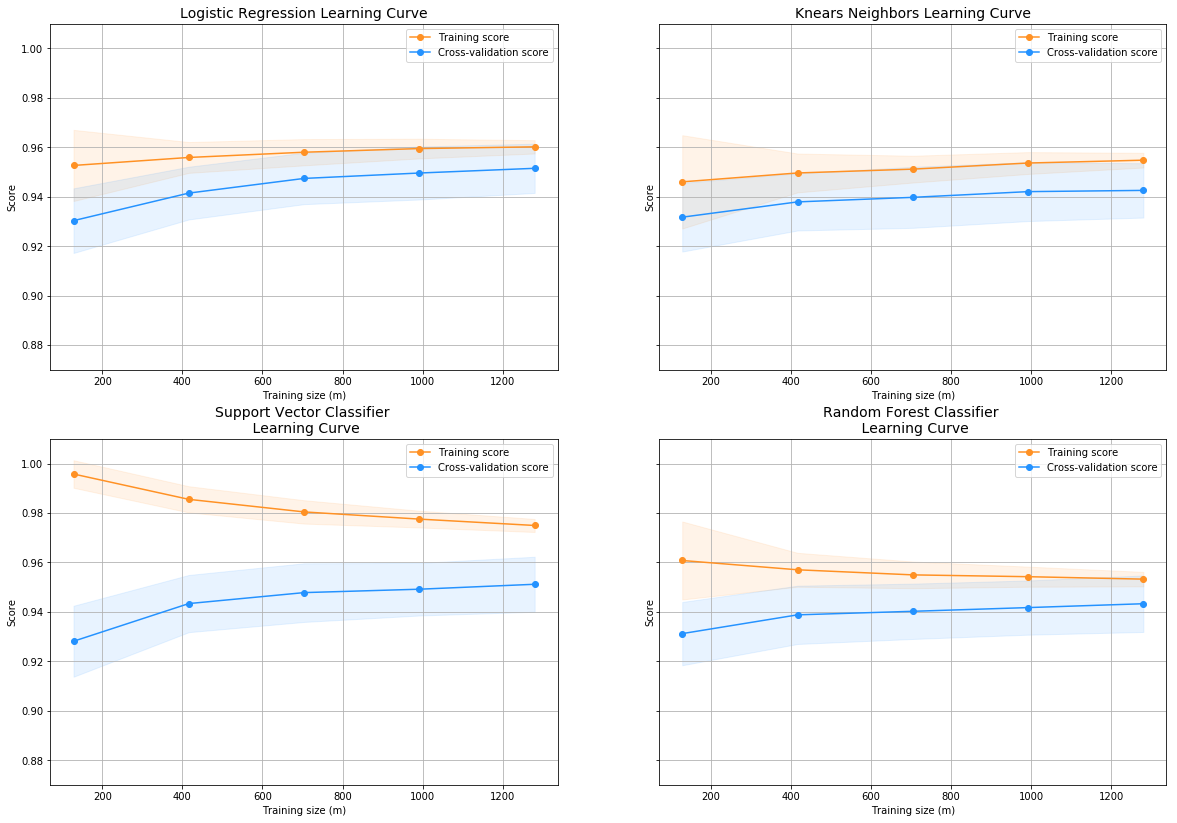

In [17]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, rfc_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [18]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

rfc_pred = cross_val_predict(rfc_clf, X_train, y_train, cv=5)

In [19]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, rfc_pred))

Logistic Regression:  0.9812591114562548
KNears Neighbors:  0.9462679943936712
Support Vector Classifier:  0.9810528585558235
Random Forest Classifier:  0.9449851638538668


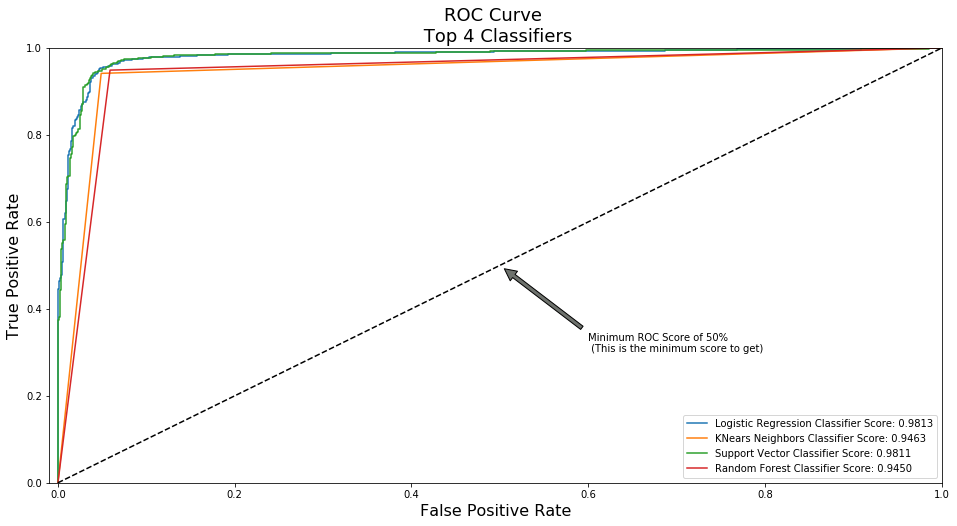

In [20]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
rfc_fpr, rfc_tpr, rfc_threshold = roc_curve(y_train, rfc_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, rfc_fpr, rfc_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rfc_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, rfc_fpr, rfc_tpr)
plt.show()

## A Deeper Look into Logistic Regression

Terms:
- **True Positives:** Correctly Classified APS Component Failures 
- **False Positives:** Incorrectly Classified APS Component Failures 
- **True Negative:** Correctly Classified Non-APS Component Failures 
- **False Negative:** Incorrectly Classified Non-APS Component Failures 
- **Precision:** True Positives/(True Positives + False Positives)
- **Recall:** True Positives/(True Positives + False Negatives)

Precision as the name says, says how precise (how sure) is our model in detecting APS component failures while recall is the amount of APS component failures cases our model is able to detect.

**Precision/Recall Tradeoff:** The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 APS component failures case in which the model is 95% precise or more that these are APS component failures. Then let's say there are 5 more cases that our model considers 90% to be a APS component failures, if we lower the precision there are more cases that our model will be able to detect.

**Summary:**

Average precision-recall score is very low, we could try to use SMOTE Technique (Over-Sampling).

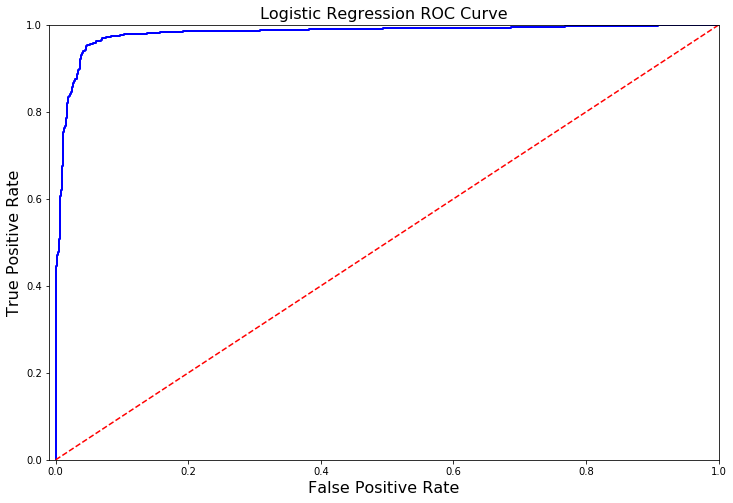

In [21]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [22]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [23]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 33)
print('Overfitting: \n')
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('---' * 33)

# How it should look like
print('---' * 33)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 33)

---------------------------------------------------------------------------------------------------
Overfitting: 

Accuracy Score: 0.82
Recall Score: 0.98
Precision Score: 0.75
F1 Score: 0.85
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.76
Recall Score: 0.98
Precision Score: 0.07
F1 Score: 0.12
---------------------------------------------------------------------------------------------------


In [24]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [25]:
original_ytest.shape

(12000,)

In [26]:
undersample_y_score.shape

(12000,)

In [27]:
# get average precision score
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.4f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.3393


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.34')

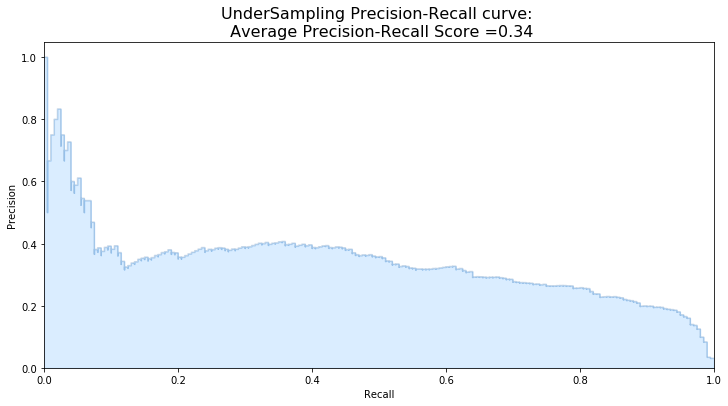

In [28]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

# SMOTE Technique (Over-Sampling)

**SMOTE** stands for Synthetic Minority Over-sampling Technique. Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems". 

**Understanding SMOTE:**

- **Solving the Class Imbalance:** SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.
- **Location of the synthetic points:** SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.
- **Final Effect:** More information is retained since we didn't have to delete any rows unlike in random undersampling.
- **Accuracy || Time Tradeoff:** Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

**Summary:**
Precision starts to descend at around 0.90. Nevertheless, our precision score is still pretty high and still we have a decent recall score which makes up to an average of 0.74 Precision-Recall score.

In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain.iloc[train], original_ytrain.iloc[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain.iloc[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain.iloc[test], original_ytrain.iloc[test]))
    precision_lst.append(precision_score(original_ytrain.iloc[test], prediction))
    recall_lst.append(recall_score(original_ytrain.iloc[test], prediction))
    f1_lst.append(f1_score(original_ytrain.iloc[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain.iloc[test], prediction))
    
print('---' * 33)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 33)

Length of X (train): 48000 | Length of y (train): 48000
Length of X (test): 12000 | Length of y (test): 12000
---------------------------------------------------------------------------------------------------

accuracy: 0.9693333333333334
precision: 0.3422280794247971
recall: 0.9012499999999999
f1: 0.49563180570756027
---------------------------------------------------------------------------------------------------


In [30]:
labels = ['non-APS Component Failures ', 'APS Component Failures']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

                             precision    recall  f1-score   support

non-APS Component Failures        1.00      0.97      0.98     11800
     APS Component Failures       0.34      0.92      0.49       200

                  micro avg       0.97      0.97      0.97     12000
                  macro avg       0.67      0.94      0.74     12000
               weighted avg       0.99      0.97      0.98     12000



In [31]:
y_score = best_est.decision_function(original_Xtest)

In [32]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.74


Fitting OverSampling Precision-Recall curve took : 0.016522884368896484 sec


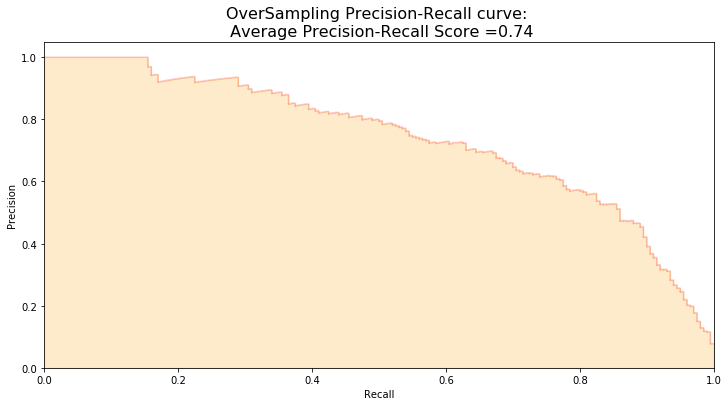

In [33]:
t0 = time.time()
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)
t1 = time.time()
print("Fitting OverSampling Precision-Recall curve took : {} sec".format(t1 -t0))

In [34]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to be using to predict the test set
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [35]:
# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :4.903687000274658 sec


# Model Evaluation on Validation & Test Set

**Confusion Matrix:**

**Positive/Negative:** Type of Class (label) ["0", "1"]   **True/False:** Correctly or Incorrectly classified by the model.


**True Negatives (Upper-Left Square):** The amount of **correctly** classified by our model of **Non-APS Component Failures.**


**False Positives (Upper-Right Square):** The amount of **incorrectly** classified cases as APS Component Failures cases, but the actual label is **Non-APS Component Failures**


**False Negatives (Lower-Left Square):** The amount of **incorrectly** classified cases as **Non-APS Component Failures** cases, but the actual label is **APS Component Failures**


**True Positives (Lower-Right Square):** The amount of **correctly** classified by our model of **APS Component Failures.**

**Summary:**
- **Validation**: When applied to validation set (i.e. test set of original train set, df), models that performed the best was **support vector classifier (SVM)**.
- **Final Testing**: When applied to unseen test set (i.e. test_df), models that performed the best was also **support vector classifier (SVM)** with a cost of **11,000**

In [36]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [37]:
# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_rfc = rfc_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
rfc_cf = confusion_matrix(y_test, y_pred_rfc)

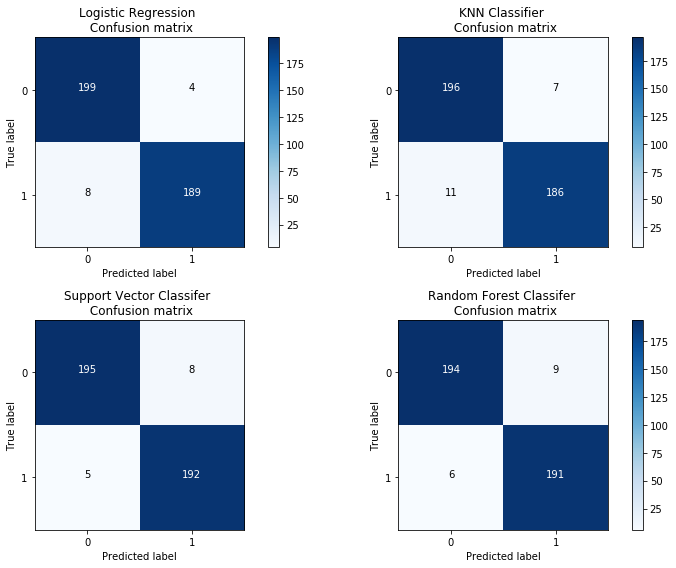

In [38]:
class_names = [0, 1]
fig = plt.figure(figsize = (12,8))

plt.subplot(2, 2, 1)
plot_confusion_matrix(log_reg_cf, classes = class_names, title = 'Logistic Regression \n Confusion matrix')

plt.subplot(2, 2, 2)
plot_confusion_matrix(kneighbors_cf, classes = class_names, title = 'KNN Classifier \n Confusion matrix')

plt.subplot(2, 2, 3)
plot_confusion_matrix(svc_cf, classes = class_names, title = 'Support Vector Classifer \n Confusion matrix')

plt.subplot(2, 2, 4)
plot_confusion_matrix(rfc_cf, classes = class_names, title = 'Random Forest Classifer \n Confusion matrix')

plt.show()

In [39]:
# Define challenge_metric
def challenge_metric(cm):
    
    """
     True class    |    Predicted class    |
                   |    0      |    1      |
     -----------------------------------------
      0            |     -     |  Cost_1   |
     -----------------------------------------
      1            |  Cost_2   |     -     |
     -----------------------------------------
     Cost_1 = 10 and cost_2 = 500

     Total_cost = Cost_1*No_Instances + Cost_2*No_Instances.
    """
    
    total_cost = cm[0][1] * 10 + cm[1][0] * 500
    total_cost = int(total_cost)
    return total_cost

In [40]:
# Note: The results shown below are not using df_test (The test set that was never touched throughout the project) but instead on the test set that was a subset of the original train set (i.e. df)
print('Logistic Regression (SMOTE) on the validation set of original train set (i.e. df):', challenge_metric(log_reg_cf))
print('K-Nearest Neighbours (Random UnderSampling) on the validation set of original train set (i.e. df):', challenge_metric(kneighbors_cf))
print('Support Vector Classifier (Random UnderSampling) on the validation set of original train set (i.e. df):', challenge_metric(svc_cf))
print('Random Forest Classfier (Random UnderSampling) on the validation set of original train set (i.e. df):', challenge_metric(rfc_cf))

Logistic Regression (SMOTE) on the validation set of original train set (i.e. df): 4040
K-Nearest Neighbours (Random UnderSampling) on the validation set of original train set (i.e. df): 5570
Support Vector Classifier (Random UnderSampling) on the validation set of original train set (i.e. df): 2580
Random Forest Classfier (Random UnderSampling) on the validation set of original train set (i.e. df): 3090


Looks like its pretty decent, now let's try to apply it on the test set that was never been seen by the model. 

In [41]:
# Preparing feature matrix and response vector for df_test
Final_X_test = df_test.drop('class', axis = 1)
Final_y_test = df_test['class']

In [42]:
# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(Final_X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(Final_X_test)
y_pred_svc = svc.predict(Final_X_test)
y_pred_rfc = rfc_clf.predict(Final_X_test)


log_reg_cf = confusion_matrix(Final_y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(Final_y_test, y_pred_knear)
svc_cf = confusion_matrix(Final_y_test, y_pred_svc)
rfc_cf = confusion_matrix(Final_y_test, y_pred_rfc)

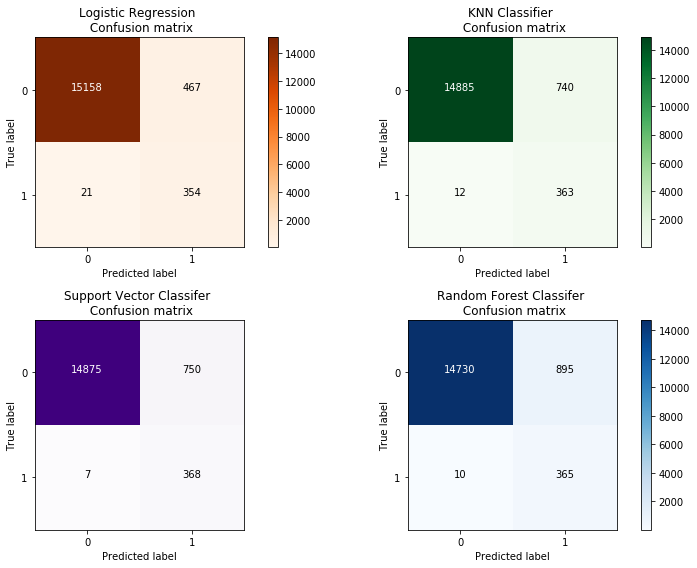

In [43]:
fig = plt.figure(figsize = (12,8))

plt.subplot(2, 2, 1)
plot_confusion_matrix(log_reg_cf, classes = class_names, title = 'Logistic Regression \n Confusion matrix', cmap=plt.cm.Oranges)

plt.subplot(2, 2, 2)
plot_confusion_matrix(kneighbors_cf, classes = class_names, title = 'KNN Classifier \n Confusion matrix', cmap=plt.cm.Greens)

plt.subplot(2, 2, 3)
plot_confusion_matrix(svc_cf, classes = class_names, title = 'Support Vector Classifer \n Confusion matrix', cmap=plt.cm.Purples)

plt.subplot(2, 2, 4)
plot_confusion_matrix(rfc_cf, classes = class_names, title = 'Random Forest Classifer \n Confusion matrix')

plt.show()

In [44]:
# Note: The results shown below are obtained using our predictive models vs original test set
print('Logistic Regression (SMOTE) on the test set (i.e. df_test):', challenge_metric(log_reg_cf))
print('K-Nearest Neighbours (Random UnderSampling) on the test set (i.e. df_test):', challenge_metric(kneighbors_cf))
print('Support Vector Classifier (Random UnderSampling) on the test set (i.e. df_test):', challenge_metric(svc_cf))
print('Random Forest Classfier (Random UnderSampling) on the test set (i.e. df_test):', challenge_metric(rfc_cf))

Logistic Regression (SMOTE) on the test set (i.e. df_test): 15170
K-Nearest Neighbours (Random UnderSampling) on the test set (i.e. df_test): 13400
Support Vector Classifier (Random UnderSampling) on the test set (i.e. df_test): 11000
Random Forest Classfier (Random UnderSampling) on the test set (i.e. df_test): 13950


**Assumptions**
- Independent and Identically distributed (IID): Models are trained on a set and tested on another, under the assumption that the two are very strongly correlated (once overfitting is taken care of).
- Machine learning system design are assumed to not have biases (implicitly or explicitly)
- Random Under-Sampling / SMOTE are assumed to help with minimizing the cost function, could have compared the cost with and without Random Under-Sampling / SMOTE
- Costs are assumed to be fixed, otherwise,  Support Vector Classifier (SVM) might not be the best model since it has a high cost inflicted from Type 1 Errors. 
- There are other predictive models could potentially give a better predictive power for this classification task but are not used for this assessment. 


**Note:** Predictions and accuracies may be subjected to change since data shuffling was used on the dataframes. The main thing is to see if our models are able to correctly classify non-APS component failures cases and APS component failures cases.